You can use the table of contents on the left to navigate. The first two sections are just code and can be skipped.

In [1]:
%matplotlib inline
from __future__ import division
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt
from collections import defaultdict

# Utility functions

In [2]:
def cast_of_season(sid, include_featured=True):
    """Return subset of actors table corresponding to cast of the given season.
    """
    return cast_of_seasons([sid], include_featured)

def cast_of_seasons(sids, include_featured=True):
    idx = casts['sid'].isin(sids)
    if not include_featured:
        idx &= ~casts['featured']
    cast = casts[idx]
    return actors.loc[cast['aid'].unique()]

## Episode ranges

In [3]:
def eps_in_range(start, end):
    epidx = (
        (episodes['epid'] >= start)
        & (episodes['epid'] <= end)
    )
    return epidx.sum()

## Usage / Airtime metrics

In [4]:
usage_metrics = {'episode_share', 'cast_episode_share', 'n_titles'}

"""A value is calculated for each title and each of the above metrics in the following way:
- episode_share: a title's episode share is 1 / the total number of 'eligible' titles in its episode
- cast_episode_share: the above, but further divided by the number of performers in the title
- n_titles: 1

To associate a value for one of the above metrics with a performer and an episode, we sum 
the values for each distinct title they appeared in (we don't double-count if they appeared
in multiple roles in a single sketch). A value of x has the following interpretations depending
on the metric in use:
- episode_share: The actor appeared in 100*x% of eligible sketches in the episode.
- cast_episode_share: The actor 'owned' 100*x% of the audience's attention during the episode.
    If they only appeared in solo sketches, this number would be the same as episode_share. The
    more other performers they share their sketches with, the lower this number becomes.
- n_titles: The actor appeared in x eligible sketches.

To get a value for these metrics over larger time spans, you should take an average over episodes.

'eligible' titles include basically all segments that cast members can normally appear in (including 
monologue and Weekend Update). See performer_title_categories in 1.5 for an enumeration.
"""

def total_airtime(aid, apps_idx, metric):
    """Return the sum of the given airtime metric over some appearances for some actor.
    apps_idx should be a boolean array that indexes into the appearances table.
    """
    assert metric in usage_metrics
    # I suspect the need to dedupe/reindex on tid is what makes this so slow
    _apps = apps[
        (apps['aid']==aid) & apps_idx
    ]
    tids = _apps['tid'].unique()
    
    if metric == 'n_titles':
        tot = len(tids)
    else:
        # The other metrics have precomputed values per title, stored in the 
        # titles table.
        _titles = titles[titles['tid'].isin(tids)]
        tot = _titles[metric].sum()
    return tot

def epid_idx_for_castyear(cast, table):
    """Return a boolean array that indexes the given table
    to match only episodes in the given cast-year.
    """
    season = seasons[seasons['sid']==cast.sid].iloc[0]
    if not pd.isnull(cast.first_epid):
        first = cast.first_epid
    else:
        first = season.first_epid
    if not pd.isnull(cast.last_epid):
        last = cast.last_epid
    else:
        last = season.last_epid
    return ((table['epid'] >= first) & (table['epid'] <= last))

def airtime_one_season(cast, metric):
    """Return avg. airtime (per given metric) over one cast-year 
    (as a row from the casts table)"""
    epidx = epid_idx_for_castyear(cast, apps)
    return total_airtime(cast.aid, epidx, metric) / cast.n_episodes

def season_airtimes(sid):
    df = casts[casts['sid']==sid].copy()
    for metric in usage_metrics:
        airs = []
        for cast in df.itertuples():
            ep_idx = epid_idx_for_castyear(cast, apps)
            at = total_airtime(cast.aid, ep_idx, metric)
            airs.append(at)
        df[metric] = airs
    return df

def overall_actor_airtime(aid, metric='episode_share'):
    res = 0
    for cast in casts[casts['aid']==aid].itertuples():
        epidx = epid_idx_for_castyear(cast, apps)
        res += total_airtime(cast.aid, epidx, metric)
    return res

def overall_avg_airtime(aid, metric='episode_share'):
    num = 0
    denom = 0
    for cast in casts[casts['aid']==aid].itertuples():
        epidx = epid_idx_for_castyear(cast, apps)
        num += total_airtime(cast.aid, epidx, metric)
        denom += cast.n_episodes
    return num / denom

# Setup

In [5]:
# TODO: If this stuff starts getting slow, might want to set appropriate indices (aid, tid, epid, etc.)
# Also, might help a bit to use categorical column types for some string cols.

# Because we used the JsonLinesItemExporter, our files don't actually contain
# well-formed json (they're missing enclosing square brackets and commas between
# items)
def load_json(path):
    with open(path) as f:
        lines = f.readlines()
        json_str = '[{}]'.format(','.join(lines))
        return pd.read_json(json_str, orient='records')

json_dir = 'output'

table_names = ['actors', 'appearances', 'characters', 'episodes', 'hosts', 'impressions',
               'seasons', 'sketches', 'titles', 'casts',
              ]

tables = {}
for name in table_names:
    path = os.path.join(json_dir, name+'.json')
    df = load_json(path)
    tables[name] = df
    
for name, table in tables.items():
    print "Loaded {:,} {}".format(len(table), name)

Loaded 288 sketches
Loaded 12,465 titles
Loaded 545 casts
Loaded 46,417 appearances
Loaded 830 episodes
Loaded 42 seasons
Loaded 849 hosts
Loaded 1,011 characters
Loaded 3,737 impressions
Loaded 2,198 actors


## Basic merges

In [6]:
# Whoops, forgot to do stupid namespace thing for casts
casts = tables['casts']
casts['aid'] = casts['aid'].apply(lambda aid: 'c_'+aid)

# Do some useful pre-emptive merge things
# Add actor_name to some tables that use aid
aid_tables = ['impressions', 'characters', 'appearances', 'hosts', 'casts']
for tablename in aid_tables:
    table = tables[tablename]
    mg = table.merge(tables['actors'], on='aid', suffixes=('_x', '_a'))\
        .rename(columns=dict(name_a='actor_name', name_x='name', name='actor_name'))\
        .drop('type', axis=1)
    tables[tablename] = mg
    assert len(mg)
    
# One extra (weird) row for season 5 we need to remove. Doesn't seem to be real ep.
episodes = tables['episodes']
episodes = episodes[pd.notnull(episodes['epno'])]
episodes['epid'] = episodes['epid'].astype(int)
tables['episodes'] = episodes
    
# Add epid, sid to appearances
apps = tables['appearances']
mg = apps.merge(tables['titles'], on='tid')\
    .drop(['category', 'order', 'skid', 'name'], axis=1)
mg = mg.merge(tables['episodes'], on='epid')\
    .drop(['aired', 'epno'], axis=1)
tables['appearances'] = mg

# Add sid to titles
titles = tables['titles']
mg = titles.merge(tables['episodes'], on='epid')\
    .drop(['aired', 'epno'], axis=1)
tables['titles'] = mg

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


## Indices

In [7]:
_table_names = ['actors', 'appearances', 'characters', 'episodes', 'hosts', 'impressions',
               'seasons', 'sketches', 'titles', 'casts',
              ]
table_to_index = dict(episodes='epid', impressions='impid', seasons='sid', titles='tid', actors='aid')
for (tablename, idx_col) in table_to_index.items():
    tables[tablename].set_index(idx_col, drop=False, inplace=True)

In [14]:
apn = actors.groupby('name').size().sort_values(ascending=False)
with pd.option_context('display.max_rows', None):
    print apn[apn > 1]

name
Alec Baldwin             42
Steve Martin             29
John Goodman             23
Jim Henson's Muppets     18
Tom Hanks                17
Buck Henry               15
Justin Timberlake        14
Paul Simon               13
George Wendt             11
Jon Hamm                 10
Drew Barrymore           10
Danny DeVito              9
Cameron Diaz              8
Melissa McCarthy          8
Scarlett Johansson        8
Madonna                   7
Eric Idle                 7
Christopher Walken        7
Paul Rudd                 7
Robert DeNiro             7
Ben Affleck               7
Elliott Gould             7
Candice Bergen            6
Sting                     6
Michael Palin             6
Paul McCartney            6
Jonah Hill                5
Albert Brooks             5
Ashton Kutcher            5
Lindsay Lohan             5
Emma Stone                5
Jerry Seinfeld            5
Gwyneth Paltrow           5
Seth Rogen                5
Bill Wegman               5
Clifford Einste

## Fix aids

In [7]:
def fix_aids():
    """There are a small number of instances where the same actor is represented by more than one
    aid, where one of them has irregular capitalization. Fix those instances.
    """
    bad_aids = {'c_Jifa', 'c_Biha', 'c_Taki', 'c_Phha', 'c_keTh', 'c_Keth', 'c_ChCH', 'c_PhHA', 'c_KeTH',
               'c_TaKI', 'c_BiHA', 'c_JiFA', 'c_ChCH', 'c_TaKI'
               }
    actors = tables['actors']
    actors = actors[~actors['aid'].isin(bad_aids)]
    tables['actors'] = actors
    fixed = {}
    for bad in bad_aids:
        good = bad[:2] + bad[2].upper() + bad[3].lower() + bad[4].upper() + bad[5].upper()
        fixed[bad] = good
    fixfn = lambda aid: fixed.get(aid, aid)
    for tname, table in tables.items():
        if tname == 'actors':
            continue
        if 'aid' in table.columns:
            table['aid'] = table['aid'].map(fixfn)     
  
fix_aids()

## Global table vars, aliases

In [8]:
for name, table in tables.items():
    # I know, I know
    globals()[name] = table
# shortcut alias
apps = appearances
imps = impressions

## Airtime stuff

In [9]:
def enrich_seasons():
    """Add some derived columns to the seasons table."""
    first_eps = []
    last_eps = []
    n_eps = []
    for season in seasons.itertuples():
        epids = episodes[episodes['sid']==season.sid]['epid']
        first_eps.append(epids.min())
        last_eps.append(epids.max())
        n_eps.append(len(epids))
    seasons['first_epid'] = first_eps
    seasons['last_epid'] = last_eps
    seasons['n_episodes'] = n_eps
    

def enrich_casts():
    """Add a column for each cast-year entry with the number of episodes the cast member
    was eligible to appear in in that season. (Normally this will be fixed per season across
    all cast members. The exception is cast members who start late in the season or end their
    run mid-season.)
    """
    n_eps = []
    fracs = []
    for cast in casts.itertuples():
        first = cast.first_epid
        if pd.isnull(first):
            first = seasons.loc[cast.sid, 'first_epid']
        last = cast.last_epid
        if pd.isnull(last):
            last = seasons.loc[cast.sid, 'last_epid']
        count = eps_in_range(first, last)
        n_eps.append(count)
        frac = count / seasons.loc[cast.sid, 'n_episodes']
        fracs.append(frac)
    casts['n_episodes'] = n_eps
    casts['season_fraction'] = fracs

enrich_seasons()
enrich_casts()

In [10]:
seasons.head(2)

,sid,year,first_epid,last_epid,n_episodes
sid,,,,,
1,1,1975,19751011,19760731,24
2,2,1976,19760918,19770521,22


In [11]:
# NB: slowish

weekend_update_categories = {'Weekend Update', 'Saturday Night News', 'SNL Newsbreak'}
live_sketch_categories = {'Sketch', 'Musical Sketch', 'Show', 'Game Show', 'Award Show'}
recorded_sketch_categories = {'Film', 'Commercial'}
# (See note in items.py re Miscellaneous category)
misc_performer_categories = {'Cold Opening', 'Monologue', 'Miscellaneous'}

# These are the categories of titles that count when computing airtime statistics. 
# Main omissions are Goodnights and Musical Performance. Also some rarer categories
# like Guest Performance, In Memoriam, Talent Entrance, etc.
performer_title_categories = set.union(
    misc_performer_categories, weekend_update_categories, live_sketch_categories, recorded_sketch_categories
)
def add_airtime_columns(force=False):
    """Add some derived columns to titles/episodes that are useful when calculating relative 'airtime'
    of cast members and guests.
    """
    if 'episode_share' in titles.columns and not force:
        return
    # If there are n eligible titles in an episode, each has an episode_share of 1/n
    titles['episode_share'] = 0.0
    titles['n_performers'] = 0
    # The same as above, but each title is further normalized by number of performers present.
    titles['cast_episode_share'] = 0.0
    for episode in episodes.itertuples():
        # XXX: Need to rescrape these eps (skipped because they have no host)
        if episode.epid in (19810411, 19841006, 19811003):
            continue
        ep_titles_ix = ((titles['epid']==episode.epid)
            & (titles['category'].isin(performer_title_categories)))
        n_titles = ep_titles_ix.sum()
        if n_titles == 0:
            print 'Warning: Found 0 titles for epid {}. Skipping.'.format(episode.epid)
            continue
            
        titles.loc[ep_titles_ix, 'episode_share'] = 1/n_titles
        perfs = []
        for title in titles[ep_titles_ix].itertuples():
            performer_aids = apps[apps['tid']==title.tid]['aid'].unique()
            perfs.append(len(performer_aids))
        titles.loc[ep_titles_ix, 'n_performers'] = perfs
        titles.loc[ep_titles_ix, 'cast_episode_share'] = (
            titles.loc[ep_titles_ix, 'episode_share'] 
            / 
            titles.loc[ep_titles_ix, 'n_performers']
        )
        
add_airtime_columns(1)

## Tenure

In [12]:
def eps_present_in_casts(cs):
    eps = 0
    for cast in cs.itertuples():
        season = seasons.loc[cast.sid]
        if not pd.isnull(cast.first_epid):
            first = cast.first_epid
        else:
            first = season.first_epid
        if not pd.isnull(cast.last_epid):
            last = cast.last_epid
        else:
            last = season.last_epid
        present_epids = apps.loc[
            (apps['aid']==cast.aid) & 
            (apps['epid'] >= first) & (apps['epid'] <= last),
            'epid'
        ].unique()
        eps += len(present_epids)
    return eps

def build_tenure():
    # n_eps: how many episodes of SNL were there between this person's start and finish?
    # eps_present: how many episodes of SNL did this person appear in as a cast member?
    # (may be less than n_eps for weeks where they weren't in the show)
    
    # Haha, so I guess some performers actually have non-contiguous runs on the show (e.g. Al
    # Franken, so some previous assumptions won't work.)
    cols = ['aid', 'actor_name', 'n_episodes', 'eps_present', 'n_seasons']
    rows = []
    cast = actors[actors['type']=='cast']
    for actor in cast.itertuples():
        aid, name = actor.aid, actor.name
        cast_years = casts[casts['aid'] == aid].sort_values(by='sid')
        if len(cast_years) == 0:
            print "Warning: {} ({}) was in actors table with type='cast', but they aren't in casts table"\
                .format(name, aid)
            continue
        n_seasons = len(cast_years)
        n_episodes = cast_years['n_episodes'].sum()
        eps_present = eps_present_in_casts(cast_years)

        row = [aid, name, n_episodes, eps_present, n_seasons]
        rows.append(row)
    return pd.DataFrame(rows, columns=cols)

tenure = build_tenure()
tenure.head(3)

,aid,actor_name,n_episodes,eps_present,n_seasons
0,c_JoLo,Jon Lovitz,91,91,5
1,c_PhHa,Phil Hartman,153,153,8
2,c_ViJa,Victoria Jackson,113,113,6


## Inferring actor gender

In [34]:
import gender_guesser.detector as gender
detector = gender.Detector()

def names_from_file(fname):
    with open(fname) as f:
        return set([name.strip().decode('utf-8') for name in f])

# First names not recognized by gender_guesser
extra_malenames = {
    'Beck', 'Mikey', 'Chevy', 'Norm',
    'Nile', 'Lin-Manuel', 'Macaulay', 'Kiefer', 'Spike', 'Kanye', 'Rainn', 'Shia',
    'Sting', 'Hulk', 'Liberace', 'Yogi', 'Merv', 'Mr.', 'O.J.', 
}
extra_femalenames = {
    'Aidy', 'Sasheer', 'Janeane', 'Danitra',
    'Lorde', 'Taraji', 'Uzo', 'Brie', 'Rihanna', 'January',
    'Anjelica', 'Oprah', 'Ann-Margret',
}

# Names misgendered by gender_guesser (or labelled as androgynous/unknown)
female_fullnames = {
    'Blake Lively', 'Terry Turner', 'Dakota Johnson', 'Cameron Diaz', 'Taylor Swift',
    'Robin Wright', 'Sydney Biddle Barrows', 'Whitney Houston', 'Morgan Fairchild',
    'Reese Witherspoon',
    'Casey Wilson', 'Nasim Pedrad', 'Noël Wells'.decode('utf-8'), 'Jan Hooks', 'Robin Duke',
}.union(names_from_file('female_names.txt'))
male_fullnames = {
    'Kyle Gass', 'The Rock', 'Jamie Foxx', 'Kelsey Grammer', 'Leslie Nielsen',
    'Kyle MacLachlan', 'Desi Arnaz Jr.', 'Desi Arnaz', 'Kyle Mooney', 'The Weeknd',
    'Bernie Sanders', 'Sacha Baron Cohen', 'A. Whitney Brown', 'Finesse Mitchell',
    'Dana Carvey', 'Tracy Morgan',
}.union(names_from_file('male_names.txt'))
# A few interesting cases: Dame Edna, RuPaul, Marilyn Manson, T.J. Jourian (transman). 
# I labelled as ffmm, respectively.

def genderize(name, confident=True):
    if name in female_fullnames:
        return 'female'
    if name in male_fullnames:
        return 'male'
    first = name.split()[0]
    if first in extra_malenames:
        return 'male'
    if first in extra_femalenames:
        return 'female'
    guess = detector.get_gender(first)
    if confident and guess == 'mostly_male':
        return 'male'
    if confident and guess == 'mostly_female':
        return 'female'
    return guess
    

actors['gender'] = actors['name'].apply(genderize)
actors['gender'].value_counts()

male       1451
female      581
unknown     144
andy         15
Name: gender, dtype: int64

# Top recurring characters

In [13]:
charapps = appearances[pd.notnull(appearances['charid'])]
char_counts = charapps.groupby('charid').size().to_frame(name='count').reset_index(level=0)
char_counts = pd.merge(char_counts, characters, on='charid')
char_counts.sort_values(by='count', ascending=False, inplace=True)
char_counts.head(20)

,charid,count,aid,name,actor_name
70,71,30,c_DoNo,Father Guido Sarducci,Don Novello
712,713,26,c_WiFo,MacGruber,Will Forte
5,6,25,c_GiRa,Emily Litella,Gilda Radner
216,217,23,c_DaCa,Church Lady,Dana Carvey
251,252,21,c_KeNe,Franz,Kevin Nealon
270,271,21,c_MiMy,Wayne Campbell,Mike Myers
315,316,20,c_AlFr,Stuart Smalley,Al Franken
252,253,20,c_DaCa,Hans,Dana Carvey
448,449,20,c_AnGa,Bobbi Mohan-Culp,Ana Gasteyer
449,450,20,c_WiFe,Marty Culp,Will Ferrell


Wow, Sarducci. Really fascinating thing is apparently Don Novello hosted one ep and co-hosted another in character as Guido Sarducci, and his appearances in those episodes aren't even counted here. Man, the Ebersol years were weird.

A *lot* of these characters are from the 90's - consistent with observation from writer in LFNY about this being the era that relied most on recurring characters, and drove them into the ground.


*Visualization concept*: x axis is time (or just season). For each popular character, do a sort of KDE of their appearances over time. 
See which characters were flash-in-the-pan and which had more of a slow burn.
Perhaps even more interesting: see which seasons used the most highly recurring characters.
For characters that appear as part of the same recurring sketch (e.g. Hans+Franz, Wayne+Garth, MacGruber+Vicki), consider them as a gestalt and just count whichever one appeared most often (probably the other character appeared in a subset of their sketches). 

# Impressions

## Top impressions (impersonator + impersonatee)

In [14]:
charapps = appearances[pd.notnull(appearances['impid'])]
char_counts = charapps.groupby('impid').size().to_frame(name='count').reset_index(level=0)
char_counts = pd.merge(char_counts, impressions, on='impid')
char_counts.sort_values(by='count', ascending=False, inplace=True)
char_counts.head(20)

,impid,count,aid,name,actor_name
1259,1291,87,c_DaHa,Bill Clinton,Darrell Hammond
645,651,38,c_DaCa,George Bush,Dana Carvey
2604,2641,33,c_FrAr,Barack Obama,Fred Armisen
1692,1724,31,c_WiFe,George W. Bush,Will Ferrell
45,46,27,c_DaAy,Jimmy Carter,Dan Aykroyd
1688,1720,27,c_DaHa,Donald Trump,Darrell Hammond
1839,1871,25,c_DaHa,Dick Cheney,Darrell Hammond
1246,1278,24,c_NoMa,Bob Dole,Norm MacDonald
3178,3226,24,c_JaPh,Barack Obama,Jay Pharoah
3302,3351,23,c_KaMc,Hillary Clinton,Kate McKinnon


Darrell Hammond's clinton wins by a *huge* margin. I think this is a combination of factors:
- Presidents get a lot of air time (more on that below)
- The Lewinsky scandal was a huge phenomenon that gave them a lot of material.
- Darrell Hammond was on the show for a long time (second only to Kenan Thompson), so he owned that impression for most of the presidency and beyond (unlike GWB and Barack Obama where the baton was passed to another performer mid-presidency).

## Most frequently impersonated 

In [15]:
# Most impersonated people (lumping together different impersonators)
charapps = appearances[pd.notnull(appearances['impid'])]
char_counts = charapps.groupby('role').size().to_frame(name='count').reset_index(level=0)
char_counts.sort_values(by='count', ascending=False, inplace=True)
char_counts.head(20)

,role,count
204,Bill Clinton,109
943,Hillary Clinton,72
851,George W. Bush,70
150,Barack Obama,57
624,Donald Trump,56
2158,Ronald Reagan,41
829,George Bush,41
1158,Jimmy Carter,37
158,Barbara Walters,31
234,Bob Dole,29


Notes:
- The top 10 (11) are all presidents or presidential candidates (top non-presidential impersonatee: Babwa)
- Suggests that political impersonations have gone up over time? The top 5 impersonations are all from '93 onward (approximately the second half of the show's lifetime)
- Interesting that Trump is already just one short of Obama after just 5 months into his presidency (the last season ended in May). Shows just how much material they had on him last season. (But interesting also to see how many of those impersonations came from before his presidential run).

## People with the most impersonators

In [16]:
impressions.groupby('name').size().sort_values(ascending=False).head(20)

name
Matthew McConaughey    10
Hillary Clinton         9
Martha Stewart          8
Ronald Reagan           7
Madonna                 7
Saddam Hussein          7
Liza Minnelli           7
Marlon Brando           7
Michael Jackson         7
Britney Spears          7
Christina Aguilera      7
Joan Rivers             6
Rod Serling             6
Wolf Blitzer            6
Woody Allen             6
Michael Gelman          6
Prince Charles          6
Adolf Hitler            6
Diana Ross              6
Marilyn Monroe          6
dtype: int64

For the most part, should expect these to be people who have had long-lasting cultural relevance (therefore many successive casts have had chances to do their own impersonations). Hillary Clinton and Madonna are good examples of this. Other factors:
- People who are easy to impersonate. Maybe they have strong 'handles' that make them easy to impersonate, or maybe you can get pretty far just by recreating aspects of their look. (Particularly a factor for impersonations done by hosts, who might have no background in comedy/impersonations, or even acting.)
- Figures whose peak of popularity came during a 'transitional' time when SNL was doing lots of cast changes.

I happen to know that Matthew McConaughey's high count is mostly because of a [single sketch](http://www.snlarchives.net/Episodes/?201311021) with a gag involving 6 Matthew McConaugheys (a throwaway gag about the surfeit of white male cast members). I think the others are legit.

# Cast strengths

## Most impressions/characters

In [17]:
df = impressions.groupby('actor_name').size().sort_values(ascending=False)
df.head(10)

actor_name
Kenan Thompson     124
Darrell Hammond    107
Fred Armisen        98
Taran Killam        95
Bill Hader          81
Jason Sudeikis      78
Phil Hartman        76
Jimmy Fallon        73
Bobby Moynihan      68
Chris Kattan        67
dtype: int64

In [18]:
df = characters.groupby('actor_name').size().sort_values(ascending=False)
df.head(10)

actor_name
Kenan Thompson    39
Fred Armisen      35
Kristen Wiig      30
Will Ferrell      27
Bobby Moynihan    26
Bill Hader        23
Horatio Sanz      22
Phil Hartman      21
Dan Aykroyd       20
Will Forte        19
dtype: int64

## Most voice work

TODO: Need to rerun full scrape since fixing voice role bug.

In [19]:
app_counts = appearances.groupby('actor_name').size().to_frame(name='roles')
voice_counts = apps[apps['voice']].groupby('actor_name').size().to_frame(name='voice_roles')
voice_counts.sort_values(by='voice_roles', ascending=False).head(10)
# TODO: buuuug

,voice_roles
actor_name,


In [20]:
from collections import defaultdict
def get_app_counts(cond):
    app_counts = defaultdict(lambda: defaultdict(int))
    #cond = appearances['sid'] == sid
    for app in appearances[cond].itertuples():
        if pd.notnull(app.charid):
            k = 'character'
        elif pd.notnull(app.impid):
            k = 'impression'
        else:
            k = 'other'
        app_counts[app.actor_name][k] += 1
    return app_counts

def app_bars(cond=None, normalize=False):
    """Where cond is some boolean array masking appearances"""
    counts = get_app_counts(cond)
    # Sort actors by total appearances
    items = sorted(counts.items(), key=lambda tup: sum(tup[1].values()), reverse=1)
    items = items[:13]
    if normalize:
        def normfn(tup):
            actor, appcounts = tup
            appsum = sum(appcounts.values())
            normed = {k: v/appsum for k, v in appcounts.items()}
            return (actor, normed)
        items = map(normfn, items)
    # Start with most appearances at the top
    items.reverse()
    actors = [it[0] for it in items]
    FS = (10, 6)
    fig, ax = plt.subplots(figsize=FS)
    acc = np.zeros(len(actors))
    x = range(len(actors))
    horizontal = True
    for k in ['impression', 'character', 'other']:
        y = [it[1][k] for it in items]
        fn = ax.barh if horizontal else ax.bar
        if horizontal:
            kwargs = dict(left=acc, label=k)
        else:
            kwargs = dict(bottom=acc, label=k)
        fn(x, y, **kwargs)
        acc += y
    ax.legend()
    if not horizontal:
        ax.set_xticks(x)
        ax.set_xticklabels(actors)
        for tick in ax.get_xticklabels():
            tick.set_rotation(45)
    else:
        ax.set_yticks(x)
        ax.set_yticklabels(actors)
    return ax

## Ratio of impressions : characters : other

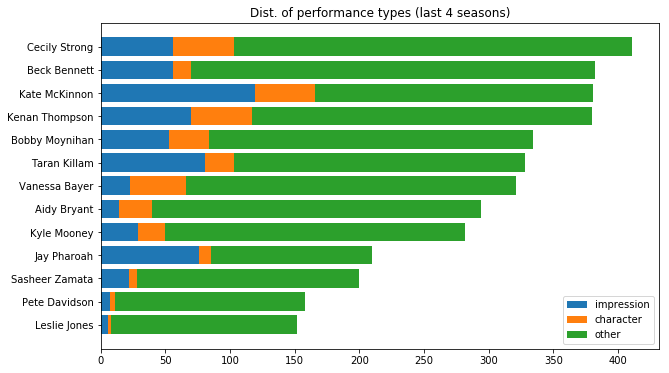

In [21]:
#app_bars(apps['sid']==39);
ax = app_bars(
    (apps['sid']>=39)
    & (apps['capacity']=='cast')
    , 0
)
ax.set_title('Dist. of performance types (last 4 seasons)');

This is kind of cool. Some observations:
- Featured players and less-used cast members generally do fewer impressions. Maybe because they get a disproportionate number of background/supporting roles.
- Jay Pharaoh is an interesting exception, being one of the least used cast members during recent seasons, but having a higher proportion of impression appearances than any other cast members. Two explanations: 1) He's really good at impressions, and 2) He was tapped to play Obama in season 38, a role that probably accounts for a pretty large % of his appearances. OTOH, he has very few character appearances.
- Conversely, Aidy/Vanessa do a lot of characters but few impressions.
- Kate McKinnon does a lot of both. (But again, I wonder how much of the blue bar is Hillary Clinton. Would be interesting to see.)

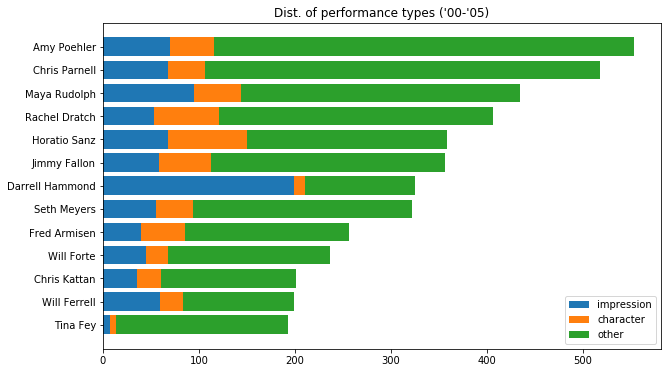

In [22]:
# (Tina Fey's tenure - '00 - '05)
ax = app_bars(
    (apps['sid']>=26)
    & (apps['sid']<=31)
    & (apps['capacity']=='cast')
    , normalize=False,
)
ax.set_title("Dist. of performance types ('00-'05)");

For her most recent hosting gig, Tina Fey actually did a [monologue](https://www.youtube.com/watch?v=n3Rv4K-OS-s) about how she had no memorable recurring characters.

This really makes it clear how focused Darrell Hammond was on impressions.

In [23]:
rec_cats = {'Film', 'Commercial', 'Cartoon'}

from collections import defaultdict
def rec_get_app_counts(cond):
    app_counts = defaultdict(lambda: defaultdict(int))
    df = appearances[cond].merge(titles, on='tid')
    for app in df.itertuples():
        if app.category in rec_cats:
            k  = 'recorded'
        else:
            k = 'live'
        app_counts[app.actor_name][k] += 1
    return app_counts

def rec_app_bars(cond=None, normalize=False):
    """Where cond is some boolean array masking appearances"""
    counts = rec_get_app_counts(cond)
    # Sort actors by total appearances
    items = sorted(counts.items(), key=lambda tup: sum(tup[1].values()), reverse=1)
    items = items[:13]
    if normalize:
        def normfn(tup):
            actor, appcounts = tup
            appsum = sum(appcounts.values())
            normed = {k: v/appsum for k, v in appcounts.items()}
            return (actor, normed)
        items = map(normfn, items)
    # Start with most appearances at the top
    items.reverse()
    actors = [it[0] for it in items]
    FS = (8, 6)
    fig, ax = plt.subplots(figsize=FS)
    acc = np.zeros(len(actors))
    x = range(len(actors))
    horizontal = True
    for k in ['recorded', 'live']:
        y = [it[1][k] for it in items]
        fn = ax.barh if horizontal else ax.bar
        if horizontal:
            kwargs = dict(left=acc, label=k)
        else:
            kwargs = dict(bottom=acc, label=k)
        fn(x, y, **kwargs)
        acc += y
    ax.legend()
    if not horizontal:
        ax.set_xticks(x)
        ax.set_xticklabels(actors)
        for tick in ax.get_xticklabels():
            tick.set_rotation(45)
    else:
        ax.set_yticks(x)
        ax.set_yticklabels(actors)
    return ax

## Recorded vs. live appearances

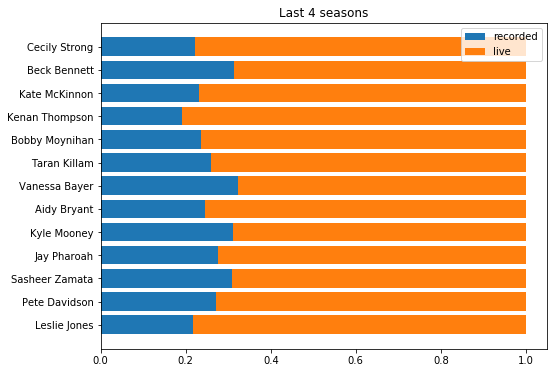

In [24]:
ax = rec_app_bars(
    (apps['sid']>=39)
    & (apps['capacity']=='cast')
    , True
)
ax.set_title('Last 4 seasons');

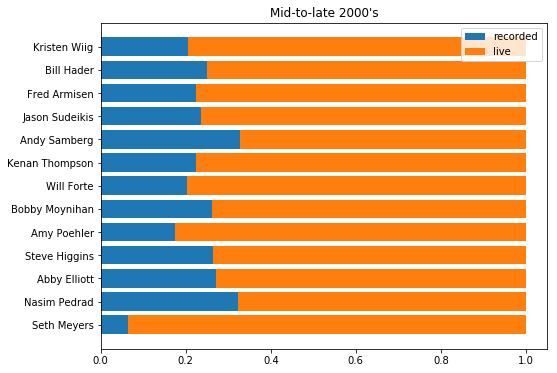

In [25]:
ax = rec_app_bars(
    (apps['sid']>=31)
    & (apps['sid']<=37)
    & (apps['capacity']=='cast')
    , normalize=1,
)
ax.set_title('Mid-to-late 2000\'s');

Samberg definitely appears in a disproportionately high # of recorded segments, but it's not as dramatic a difference as I expected.

In [26]:
from adjustText import adjust_text
# TODO: There's probably a more effective way to visualize this. Maybe do a stacked bar
# for each performer, and arbitrarily assign a color to each distinct impression (with
# its height being the # of times it was performed)

# TODO: maybe helpful to color dots by featured vs. repertory

def scatter_impressions(sids, ax=None, transpose=True, characters=False):
    if isinstance(sids, int):
        sids = [sids]
    if ax is None:
        FS = (13, 6)
        fig, ax = plt.subplots(figsize=FS)
    ppl = cast_of_seasons(sids)
    xy = []
    sought_col = 'charid' if characters else 'impid'
    for actor in ppl.itertuples():
        idx = (apps['aid']==actor.aid) & apps['sid'].isin(sids) & pd.notnull(apps[sought_col])
        imp_apps = apps[idx]
        distinct = len(imp_apps[sought_col].unique())
        row = [distinct, len(imp_apps)]
        xy.append(row)
    xy = np.array(xy)
    ax.scatter(xy[:,0+transpose], xy[:,1-transpose])
    
    texts = []
    for (coords, actor) in zip(xy, ppl.itertuples()):
        #ax.annotate(actor.name, coords)
        txt = ax.text(coords[0+transpose], coords[1-transpose], actor.name)
        texts.append(txt)
    adjust_text(texts, arrowprops=dict(arrowstyle='->', lw=.5))
        
    thing = 'character' if characters else 'impression'
    ax_labels = ['# distinct {}s'.format(thing), '{} appearances'.format(thing.capitalize())]
    ax.set_xlabel(ax_labels[0+transpose])
    ax.set_ylabel(ax_labels[1-transpose])
    # x = y baseline
    minmax = min(xy[:,0].max(), xy[:,1].max())
    ax.plot([0, minmax], [0, minmax], linestyle='--', lw=.5, color='b')
    #ax.plot([0, minmax*2], [0, minmax], linestyle='--', lw=.5, color='b')
    #ax.plot([0, minmax*3], [0, minmax], linestyle='--', lw=.5, color='b')
    return ax

## Impression appearances vs. distinct impressions

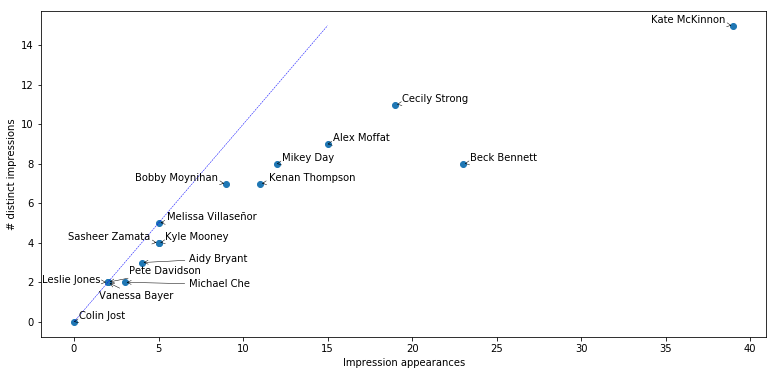

In [27]:
scatter_impressions(42);

Beck Bennett is kind of a surprising. He did Putin 7 times in s42, Mike Pence 6 times, and Jake Tapper 5 times. Really shows how much political stuff they put on air last year. 
Cecily Strong's biggest recurring impression last year was Melania Trump, but she mostly did lots of one-offs as various debate moderators and news personalities. 

It's pretty remarkable how far ahead of the pack Kate McKinnon is. She had a couple of huge political impressions last season (Hillary and Kellyanne Conway), but even though she was doing those every week, she still had a greater variety of impersonations than anyone else. 

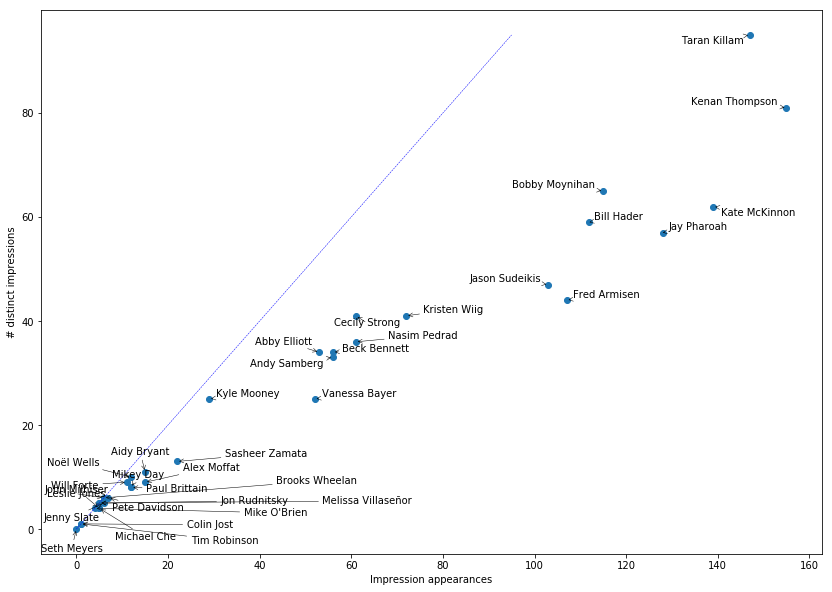

In [28]:
fig, ax = plt.subplots(figsize=(14, 10))
scatter_impressions(range(35, 43), ax);

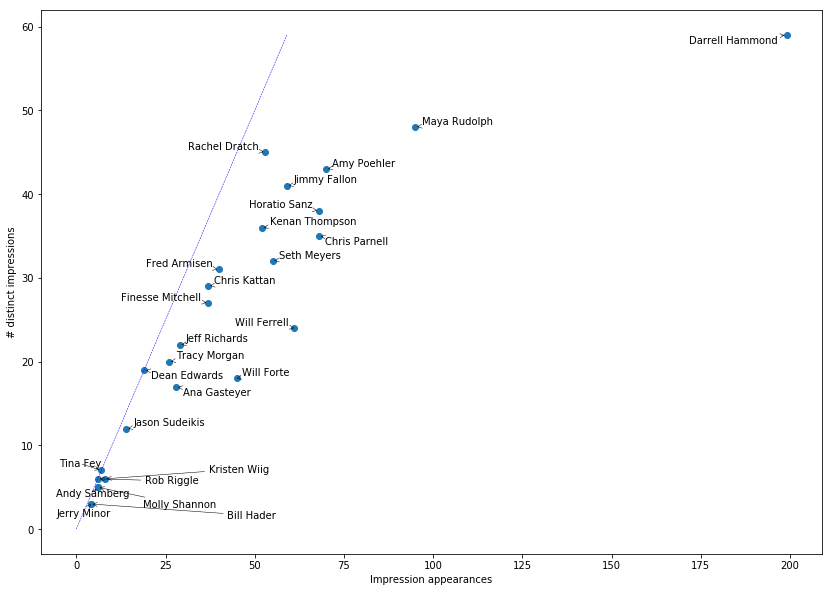

In [29]:
fig, ax = plt.subplots(figsize=(14, 10))
scatter_impressions(range(26, 32), ax);

## Character appearances vs. distinct chars

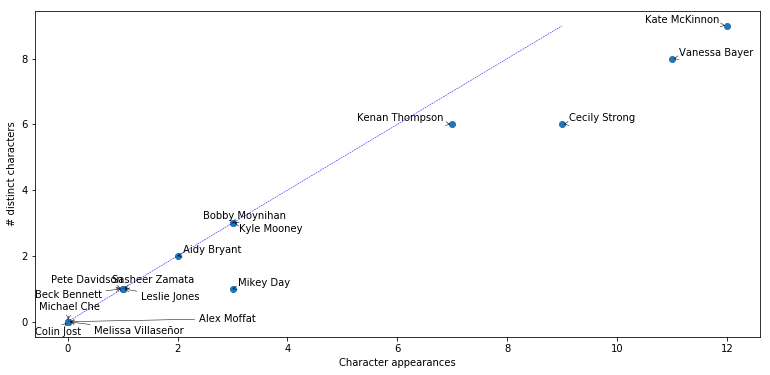

In [30]:
scatter_impressions(42, characters=True);

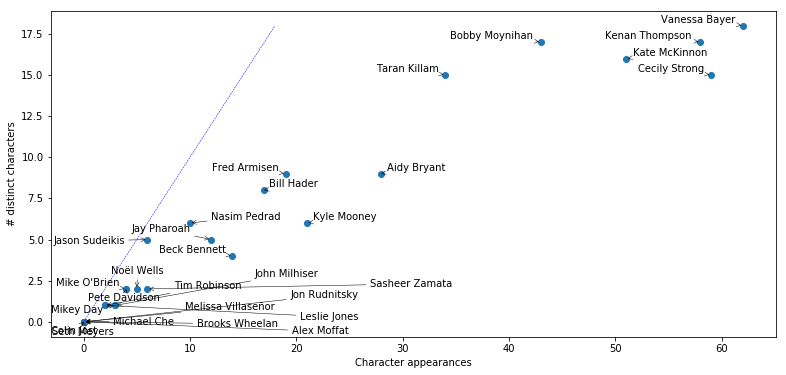

In [31]:
scatter_impressions(range(38, 43), characters=True);

# Cast member appearance rates

In [35]:
M_COLOR = 'dodgerblue'
F_COLOR = 'magenta'
def scatter_sketches_and_episodes():
    df = tenure.copy()
    df['gender'] = actors.loc[df['aid'], 'gender'].values
    df['n_titles'] = df['aid'].apply(lambda aid: overall_actor_airtime(aid, 'n_titles'))
    FS = (15, 8)
    fig, ax = plt.subplots(figsize=FS)
    xcol = 'n_titles'
    ycol= 'n_episodes'
    x = df[xcol]
    y = df[ycol]
    igirl = df['gender'] == 'female'
    ax.scatter(x[igirl], y[igirl], alpha=.4, color=F_COLOR)
    ax.scatter(x[~igirl], y[~igirl], alpha=.6, color=M_COLOR)
    ax.set_xlabel('# sketches')
    ax.set_ylabel('# episodes')
    ax.set_xlim(left=0)
    ax.set_ylim(bottom=0)
    
    label_min_x = 700
    label_min_y = 175
    for xx, yy, name in df[[xcol, ycol, 'actor_name']].itertuples(index=False):
        if xx >= label_min_x or yy >= label_min_y:
            ax.annotate(name, xy=(xx+10,yy-2.5))
    
    return ax

## Most sketches and episodes

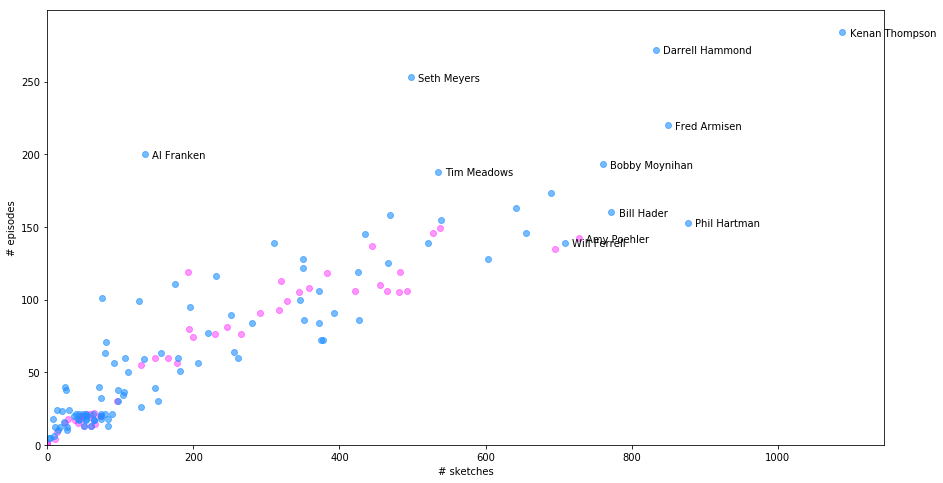

In [36]:
ax = scatter_sketches_and_episodes();

## Most sketches per episode

In [37]:
df = tenure.copy()
df['avg_sketches_per_ep'] = df['aid'].apply(lambda aid: overall_avg_airtime(aid, 'n_titles'))
df['avg_episode_share'] = df['aid'].apply(overall_avg_airtime)
df['avg_cast_episode_share'] = df['aid'].apply(lambda aid: overall_avg_airtime(aid, 'cast_episode_share'))

In [38]:
df.sort_values(by='avg_episode_share', ascending=False).head(15)

,aid,actor_name,n_episodes,eps_present,n_seasons,avg_sketches_per_ep,avg_episode_share,avg_cast_episode_share
1,c_PhHa,Phil Hartman,153,153,8,5,0.519618,0.126509
43,c_BiMu,Bill Murray,72,71,4,5,0.479165,0.096002
96,c_MiMc,Michael McKean,26,26,2,4,0.444854,0.092499
40,c_KrWi,Kristen Wiig,135,135,7,5,0.439659,0.088216
61,c_WiFe,Will Ferrell,139,136,7,5,0.435013,0.102156
62,c_AmPo,Amy Poehler,142,139,8,5,0.429572,0.084113
103,c_JaGa,Janeane Garofalo,14,14,1,4,0.428391,0.081043
52,c_TaKi,Taran Killam,128,127,6,4,0.423825,0.068577
22,c_CeSt,Cecily Strong,105,105,5,4,0.418496,0.069650
58,c_BiHa,Bill Hader,160,159,8,4,0.411912,0.074812


In many cases, these are the MVP players of their time. 

Some are just highly competent workhorses who were written into a lot of sketches but never really achieved star status during their time on the show or did any hugely popular recurring characters or impressions:
- Cecily Strong
- Taran Killam
- Beck Bennett (He seems to get a lot of supporting/straight man roles. Notably he has the lowest cast_episode_share on the list)
- Jon Lovitz
- Phil Hartman? (Adam Sandler called him 'the glue' that held the show together)

Not sure about the story with Michael McKean. He played Bill Clinton after Phil Hartman left, so I guess that helped. Also not sure about Randy Quaid.

Janeane Garofalo is the most surprising example. She hated her time on the show, and I got the impression she didn't get along well with many of the writers or other cast members. So how was she in so many sketches? When she was on, there were only 2 other female cast members, Ellen Cleghorne and Laura Kightlinger. Laura was a featured player and not used in many sketches, so I guess Janeane was the default choice when they needed a white lady in a sketch or for an impression? Still surprising.


## Fewest sketches per episode

In [39]:
df.sort_values(by='avg_episode_share', ascending=True).head(15)

,aid,actor_name,n_episodes,eps_present,n_seasons,avg_sketches_per_ep,avg_episode_share,avg_cast_episode_share
133,c_EmPr,Emily Prager,1,0,1,0,0.000000,0.000000
110,c_LaMe,Laurie Metcalf,1,0,1,0,0.000000,0.000000
145,c_GeCo,George Coe,24,8,1,0,0.032136,0.008668
115,c_DaVi,Dan Vitale,18,4,1,0,0.035399,0.006103
49,c_ToSc,Tom Schiller,5,1,1,0,0.044444,0.003069
15,c_RoSm,Robert Smigel,40,22,2,0,0.054563,0.008938
104,c_DoNo,Don Novello,38,18,2,0,0.061025,0.020717
45,c_AlFr,Al Franken,200,101,11,0,0.061207,0.013368
108,c_AWBr,A. Whitney Brown,101,56,6,0,0.067800,0.017463
134,c_MiOD,Michael O'Donoghue,24,14,1,1,0.075814,0.017624


Cast members with the fewest appearances per episode. Mostly players who just didn't manage to make much of an impact or get in a lot of sketches during their (short) time on the show.

Some were much more active with the show's writing, e.g. Robert Smigel, Al Franken, A. Whitney Brown, Fred Wolf, Jim Downey. The latter 2 were head writers for a while.

(#TODO: I think Emily Prager was legit not even in the single episode she was credited for. Laurie was in one, but that was one of the episodes that failed to scrape. George Coe has a higher n_episodes than he should - same with Michael O'Donoghue. snlarchive just has incomplete cast metadata for s1: http://www.snlarchives.net/Seasons/?1975)

## Most missed shows

In [42]:
df = tenure.copy()
df['missed'] = df['n_episodes'] - df['eps_present']
df.sort_values(by='missed', ascending=False).head(20)

,aid,actor_name,n_episodes,eps_present,n_seasons,missed
45,c_AlFr,Al Franken,200,101,11,99
108,c_AWBr,A. Whitney Brown,101,56,6,45
104,c_DoNo,Don Novello,38,18,2,20
15,c_RoSm,Robert Smigel,40,22,2,18
145,c_GeCo,George Coe,24,8,1,16
115,c_DaVi,Dan Vitale,18,4,1,14
51,c_MaRu,Maya Rudolph,146,132,9,14
13,c_DaSp,David Spade,116,104,6,12
47,c_FrWo,Fred Wolf,23,13,2,10
134,c_MiOD,Michael O'Donoghue,24,14,1,10


I'm guessing Maya Rudolph missed a bunch of episodes during and after her pregnancy.

I think I read somewhere that Mike Myers was allowed to miss some shows when he was shooting films. Maybe similar situation for David Spade?

I think most of the rest are just examples of performers not having any of their sketches make it to air, rather than them not being able to perform due to some extenuating circumstances.

Again, several were doing more writing than performing (Al Franken, Fred Wolf, Jim Downey).

Apparently [A. Whitney Brown](http://www.snlarchives.net/Cast/?AWBr) was a featured player in all 6 of his seasons. I wonder if that's a record.
Hm, no, I guess not. Al Franken was a FP on all **11** of his seasons.

# A typical episode

In [43]:
# Categories for live sketches
sketch_cats = ['Sketch', 'Musical Sketch', 'Show', 'Game Show', 'Award Show']

rec_cats = ['Film', 'Commercial', 'Cartoon']

other_cats = ['Guest Performance', 'Miscellaneous', 'In Memoriam', 'Talent Entrance', 'Intro',
              'Encore Presentation',
             ]
collapse_other = 1 # Give all 'other' categories the same color
cat_to_color = {}
for i, skc in enumerate(sketch_cats):
    g = 120 + i * ((254-120)/(len(sketch_cats)-1))
    cat_to_color[skc] = (254, g, 86)
    
for i, skc in enumerate(rec_cats):
    b = 13 + i * ((254-13)/(len(rec_cats)-1))
    if skc == 'Commercial':
        b += 30
    cat_to_color[skc] = (86, 254, b)
    
for i, skc in enumerate(other_cats):
    if collapse_other:
        cat_to_color[skc] = (86, 86, 254)
    else:
        z = 13
        r = z + i * ((254-z)/(len(other_cats)-1))
        cat_to_color[skc] = (r, 86, 254)
    
# Whoops, matplotlib wants channels in [0,1]
cat_to_color = {cat: map(lambda ch: ch/255, color_tup) for (cat, color_tup) in cat_to_color.items()}

def cat_avg_per_season(cat, norms=None):
    res = []
    # I know there are cleverer ways to do these things, but working with a small dataset,
    # I'm enjoying the simplicity of for loops over torturing myself reading inscrutable
    # pandas documentation.
    for i, season in enumerate(seasons.itertuples()):
        eps_this_season = (episodes['sid'] == season.sid).sum()
        if isinstance(cat, list) or isinstance(cat, set):
            cat_cond = titles['category'].isin(cat)
        else:
            cat_cond = titles['category'] == cat
        cats_this_season = (cat_cond & (titles['sid'] == season.sid)).sum()
        avg = cats_this_season / eps_this_season
        if norms:
            avg = avg / norms[i]            
        res.append(avg)
    return res

# Whether to normalize all bars to sum to 1
normalize = 1
norms = None
if normalize:
    allcats = set(cat_to_color.keys())
    norms = cat_avg_per_season(allcats)
    
bar_width = .8
sids = seasons['sid'].values

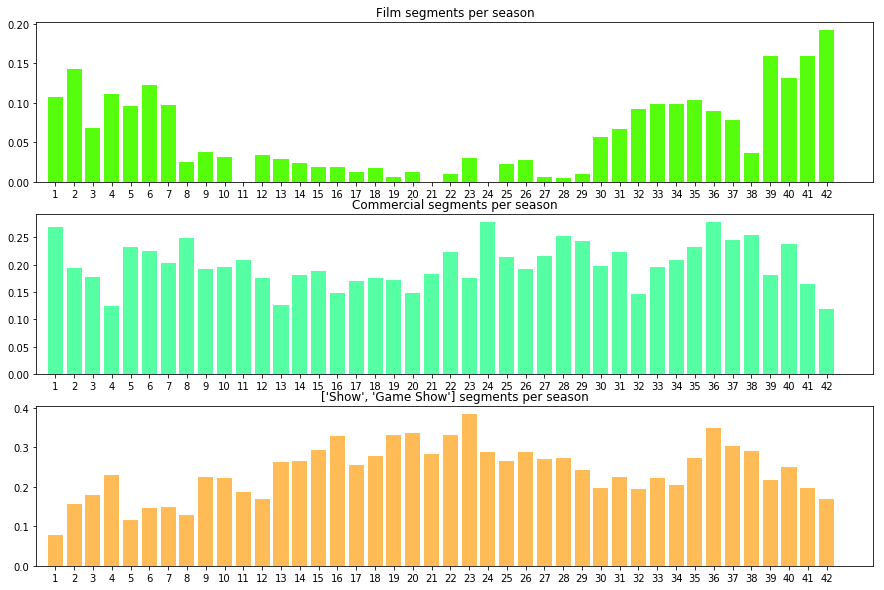

In [44]:
FS = (15, 10)
fig, axes = plt.subplots(3, 1, figsize=FS)
for cat, ax in zip(['Film', 'Commercial', ['Show', 'Game Show']], axes):
    ax.set_title('{} segments per season'.format(cat))
    if isinstance(cat, list):
        color = cat_to_color[cat[0]]
    else:
        color = cat_to_color[cat]
    y = cat_avg_per_season(cat, norms)
    ax.bar(sids, y, bar_width, color=color)
    ax.set_xlim(left=0)
    ax.set_xticks(range(1, sids[-1]+1))

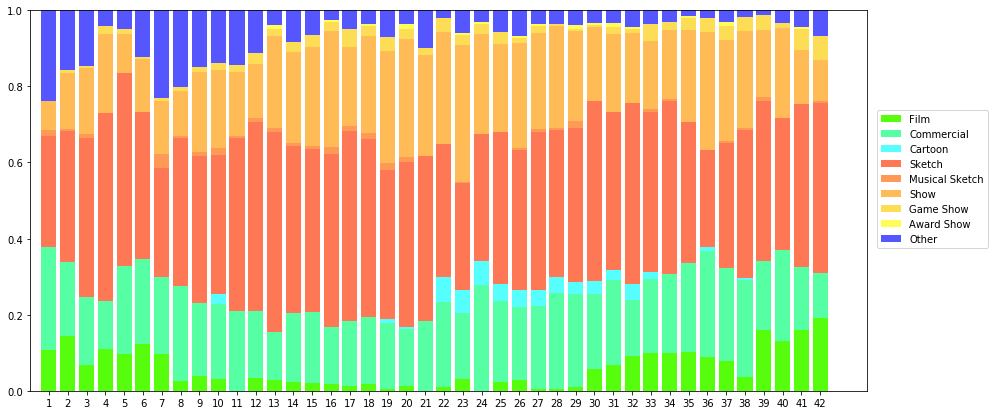

In [45]:
FS = (15, 7)
fig, ax = plt.subplots(figsize=FS)
acc = np.zeros(len(sids))
#for cat in sketch_cats + rec_cats + other_cats:
for cat in rec_cats + sketch_cats + other_cats:
    color = cat_to_color[cat]
    y = cat_avg_per_season(cat, norms)
    label = cat
    if cat in other_cats and collapse_other:
        label = 'Other' if cat == 'Guest Performance' else None
    ax.bar(sids, y, bar_width, bottom=acc, color=color, label=label)
    acc += y
ax.legend(bbox_to_anchor=(1.15,.75))
ax.set_xlim(left=0)
ax.set_xticks(range(1, sids[-1]+1));

Some trends:

- The first 10 years have a lot more 'miscellaneous' stuff. Which makes sense - it took a while for SNL to become SNL. During the early years, they were trying a bunch of things that eventually dropped from the lineup like: guest stand-up comedy sets, Penn and Teller magic shows, bits where cast members would directly address the audience, 
- The boom in films in the last ten years or so is really obvious. (Andy Samberg joined the cast in season 31). The nadir at season 38 is interesting. That's the first season after Samberg left.
- The most recent season is interesting for its anonamlously low number of commercials, and (Game|Award|) Show sketches. Maybe shows were so jammed with political sketches that pop culture stuff had to take a backseat.
    - I wonder if this is generally true of election years.

# Most / Least valuable hosts

In [46]:
# TODO: Kinda slow (~20 s?)
def host_usage(aid, epid, metric):
    assert metric in usage_metrics
    tids = apps[
        (apps['epid']==epid) & (apps['aid']==aid)
    ]['tid'].unique()
    if metric == 'n_titles':
        return len(tids)
    host_titles = titles[titles['tid'].isin(tids)]
    return host_titles[metric].sum()

hosts_per_epid = hosts.groupby('epid').size()

usage = {mt: [] for mt in usage_metrics}
for host in hosts.itertuples():
    for metric in usage_metrics:
        dest = usage[metric]
        # Don't count shows with multiple hosts.
        if hosts_per_epid[host.epid] > 1:
            dest.append(None)
            continue
        x = host_usage(host.aid, host.epid, metric)
        dest.append(x)

df = hosts.copy()
for metric in usage_metrics:
    df[metric] = usage[metric]

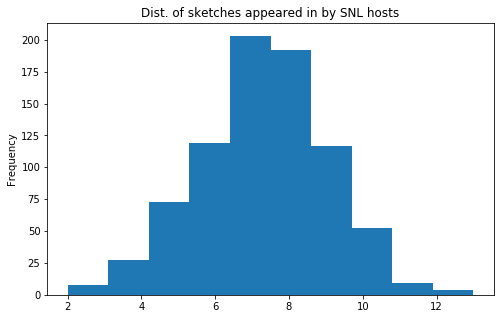

In [47]:
df['n_titles'].plot.hist(title='Dist. of sketches appeared in by SNL hosts', figsize=(8,5));

## Most used

In [48]:
# Hosts who appeared in the most sketches on their episode
df.sort_values(by='n_titles', ascending=False).head(10)

,aid,epid,actor_name,cast_episode_share,n_titles,episode_share
213,g_2552,20100508,Betty White,0.274786,13.0,1.000000
819,g_48,19751213,Richard Pryor,0.256310,12.0,0.600000
101,c_TrMo,20090314,Tracy Morgan,0.161429,12.0,0.800000
235,c_MoSh,20070512,Molly Shannon,0.262121,12.0,0.923077
104,c_AnSa,20140517,Andy Samberg,0.167865,11.0,0.916667
378,g_1782,19991113,Garth Brooks,0.218162,11.0,0.846154
18,c_KrWi,20130511,Kristen Wiig,0.147042,11.0,0.909091
207,g_2387,20081018,Josh Brolin,0.193413,11.0,0.733333
412,g_1646,19980117,Sarah Michelle Gellar,0.164286,11.0,0.785714
152,g_2824,20130302,Kevin Hart,0.247950,11.0,0.916667


Wow, Betty White is a legend. She was in literally every single segment of the show except for Jay-Z's musical performances (she didn't want to upstage him I guess).

In [49]:
# Same as above, but normalized by number of sketches in the show
df.sort_values(by='episode_share', ascending=False).head(10)

,aid,epid,actor_name,cast_episode_share,n_titles,episode_share
461,g_1451,19950513,David Duchovny,0.189550,9.0,1.000000
125,c_WiFe,20090516,Will Ferrell,0.299239,9.0,1.000000
213,g_2552,20100508,Betty White,0.274786,13.0,1.000000
235,c_MoSh,20070512,Molly Shannon,0.262121,12.0,0.923077
152,g_2824,20130302,Kevin Hart,0.247950,11.0,0.916667
104,c_AnSa,20140517,Andy Samberg,0.167865,11.0,0.916667
348,g_2039,20030315,Salma Hayek,0.253247,10.0,0.909091
18,c_KrWi,20130511,Kristen Wiig,0.147042,11.0,0.909091
73,c_SaSi,20141004,Sarah Silverman,0.222944,10.0,0.909091
122,g_2871,20131005,Miley Cyrus,0.166089,10.0,0.909091


Props to Mulder and Will Ferrell. Also 100% attendance, their shows just had fewer sketches.

5 of the top 10 are former cast members, which isn't that surprising. They know how SNL works, and they're good at it. 

In [50]:
# Same as the above but additionally weight each sketch by the inverse of 
# the number of performers in it.
df.sort_values(by='cast_episode_share', ascending=False).head(10)

,aid,epid,actor_name,cast_episode_share,n_titles,episode_share
469,g_1427,19950211,Bob Newhart,0.394841,9.0,0.900000
685,c_EdMu,19841215,Eddie Murphy,0.382784,10.0,0.769231
833,g_205,19770312,Sissy Spacek,0.333333,9.0,0.642857
801,g_129,19760731,Kris Kristofferson,0.326923,9.0,0.692308
724,g_619,19830122,Lily Tomlin,0.324074,9.0,0.600000
657,g_717,19840414,George McGovern,0.323593,8.0,0.727273
641,g_831,19860215,Jerry Hall,0.314815,8.0,0.888889
813,g_78,19760131,Dick Cavett,0.312500,6.0,0.375000
577,g_1053,19890520,Steve Martin,0.310256,8.0,0.615385
586,g_1028,19890128,Tony Danza,0.308275,8.0,0.615385


So, in some sense, Bob Newhart and Eddie Murphy personally 'owned' almost 40% of the shows they hosted, which is pretty impressive.

Rationale for this one is that carrying a sketch solo or with just one other performer is a lot of responsibility. A less adept host might get put in a lot of sketches, but with lots of cast members around them to do the heavy lifting.

Interesting that this metric diverges pretty significantly from the other two. I guess it's pretty volatile compared to the others. A sketch with 7 or 8 other performers (which is not that uncommon) is worth almost nothing under this metric compared to a solo sketch.
Also of course fails to account for the size of roles. Your score might get dragged down just because of a few background roles with few or no lines.

Interesting that all these episodes are pre-y2k. 

## Least used

In [51]:
# Hosts who appeared in the fewest sketches
df.sort_values(by='n_titles', ascending=True).head(10)

,aid,epid,actor_name,cast_episode_share,n_titles,episode_share
708,g_523,19811114,Bernadette Peters,0.081633,2.0,0.142857
761,g_316,19781021,Frank Zappa,0.043750,2.0,0.250000
694,g_655,19830514,Ed Koch,0.137500,3.0,0.300000
695,g_578,19820522,Olivia Newton-John,0.070707,3.0,0.272727
728,g_603,19821113,Robert Blake,0.062346,3.0,0.333333
824,g_10,19751018,Paul Simon,0.098958,3.0,0.375000
789,g_286,19780311,Art Garfunkel,0.083333,3.0,0.300000
785,g_298,19780415,Michael Sarrazin,0.104545,3.0,0.272727
557,g_1057,19890930,Bruce Willis,0.135606,4.0,0.363636
800,g_235,19770924,Steve Martin,0.146429,4.0,0.400000


In [52]:
# As above, but normalized by # sketches in show
df.sort_values(by='episode_share', ascending=True).head(30).reset_index(drop=True)

,aid,epid,actor_name,cast_episode_share,n_titles,episode_share
0,g_523,19811114,Bernadette Peters,0.081633,2.0,0.142857
1,g_1,19751011,George Carlin,0.210526,4.0,0.210526
2,g_40,19751115,Robert Klein,0.161458,4.0,0.250000
3,g_316,19781021,Frank Zappa,0.043750,2.0,0.250000
4,g_514,19811031,Donald Pleasence,0.061111,4.0,0.250000
5,g_23,19751025,Rob Reiner,0.105903,4.0,0.250000
6,g_471,19810124,Robert Hays,0.091667,5.0,0.250000
7,g_476,19810207,Sally Kellerman,0.075000,4.0,0.250000
8,g_291,19780325,Christopher Lee,0.122222,5.0,0.266667
9,g_661,19831008,Brandon Tartikoff,0.166667,4.0,0.266667


In [53]:
#df.sort_values(by='cast_episode_share', ascending=True).head(10)
"""Shelley Duvall is an interesting example. She was in 60% of sketches, but her 'cast_episode_share' is low because so many of them had huge numbers of performers. Like, look at all the people in this sketch: http://www.snlarchives.net/Episodes/?197705143
While I think it's true that a weak performer will probably never get a segment to themselves, or a duo sketch, I don't think the penalty should necessarily be linear with number of performers. You can hide a bad host in a sketch with 5 cast members just as easily as you can in one with 10.
(Another interesting feature of the Duvall episode is that there's seemingly no monologue?)""";

Some general comments on least-used hosts (over all metrics):
- A fair number of non-actors (Zappa, Olivia Newton-John, Ed Koch, Brandon Tartikoff - an NBC exec). Surprisingly, no sports figures jump out (though I don't know how many I'd recognize).
- Zappa was a legendarily bad host (and I think banned from the show after), so it's not surprising to see him near the top on all metrics. I think I heard that Robert Blake was also thought poorly of.
- I wonder how many of these people were invited back?
- Of the bottom 30, the most recent episode is when Roma Downey hosted in 1998 (#28 on the list). All others are from the 70's or the 80's. Suggests maybe that over the last couple decades, the show has been more forgiving of weak hosts, and made more of an effort to carry them through the show?
    - Or, alternatively, there's just been an overall increase in the prominence of the host over time. Supported by the fact that the episodes with the 10 most active hosts are almost all post-y2k. 

# Gender stuff

In [54]:
def g_lookup(aid):
    try:
        return actors.loc[aid, 'gender']
    except KeyError:
        return None
impressions['actor_gender'] = impressions['aid'].apply(g_lookup)
impressions['gender'] = impressions['name'].apply(lambda n: genderize(n, confident=True))
imps['queen'] = (imps['gender']=='female') & (imps['actor_gender']=='male')
imps['king'] = (imps['gender']=='male') & (imps['actor_gender']=='female')

In [55]:
queens = imps[imps['queen']]
kings = imps[imps['king']]
print "Found {} drag performances by male actors, and {} by female actors".format(
    len(queens), len(kings)
)
queens.head()

Found 133 drag performances by male actors, and 40 by female actors


,aid,impid,name,actor_name,actor_gender,gender,queen,king
impid,,,,,,,,
692,c_PhHa,692,Barbara Bush,Phil Hartman,male,female,True,False
1028,c_PhHa,1028,Dame Edna,Phil Hartman,male,female,True,False
911,c_ChRo,911,Whoopi Goldberg,Chris Rock,male,female,True,False
2874,c_BoMo,2874,"Nicole ""Snooki"" Polizzi",Bobby Moynihan,male,female,True,False
3137,c_BoMo,3137,Rosie O'Donnell,Bobby Moynihan,male,female,True,False


In [56]:
unk = actors[actors['gender']=='unknown']
mm = actors[actors['gender']=='mostly_male']
mf = actors[actors['gender']=='mostly_female']

In [57]:
def add_titles_gender_ratio():
    title_to_gendercounts = defaultdict(lambda: defaultdict(int))
    # Don't double-count actors appearing in multiple roles in one sketch
    tids_aids = apps.drop_duplicates(subset=['tid', 'aid'])
    for app in tids_aids.itertuples():
        # XXX: hack. Remove me afrer rerunning (fixed above in 2.1)
        if app.aid in {'c_PhHA', 'c_KeTH', 'c_TaKI', 'c_BiHA', 'c_JiFA', 'c_ChCH',}:
            gender = 'male'
        else:
            gender = actors.loc[app.aid, 'gender']
        title_to_gendercounts[app.tid][gender] += 1
    df = pd.DataFrame.from_dict(title_to_gendercounts, orient='index')
    df['female'].fillna(0, inplace=True)
    df['male'].fillna(0, inplace=True)
    titles['n_female'] = df['female']
    titles['n_male'] = df['male']
    titles['female_ratio'] = titles['n_female'] / (titles['n_female'] + titles['n_male'])
    
add_titles_gender_ratio()
titles.head(2)

,category,epid,name,order,skid,tid,sid,episode_share,n_performers,cast_episode_share,n_female,n_male,female_ratio
tid,,,,,,,,,,,,,
1992051616,Goodnights,19920516,None,15,NaN,1992051616,17,0.000000,0,0.000000,NaN,NaN,NaN
1992051615,Sketch,19920516,Bad Expectant Mother,14,NaN,1992051615,17,0.083333,4,0.020833,1.0,3.0,0.25


In [1]:
# TODO: Maybe don't include voice roles? Don Pardo/Steve Higgins as announcer could 
# really skew numbers.
# OTOH, those guys actually seem to account for a surprisingly small minority of 'announcer'
# roles. They usually go to cast members. 
# There's also the question of whether such roles should count toward our accounting of
# male/female representation on the show (if everyone on screen in a sketch is male but 
# a woman does the voiceover, do we want to call it a mixed gender sketch rather than all-male?)
#apps['role'].value_counts().sort_values(ascending=False).head(20)
#apps[apps['role']=='announcer'].sample(20)

weekend_update_categories = {'Weekend Update', 'Saturday Night News', 'SNL Newsbreak'}
live_sketch_categories = {'Sketch', 'Musical Sketch', 'Show', 'Game Show', 'Award Show'}
recorded_sketch_categories = {'Film', 'Commercial'}
# (See note in items.py re Miscellaneous category)
misc_performer_categories = {'Cold Opening', 'Monologue', 'Miscellaneous'}
# These are the categories of titles that count when computing airtime statistics. 
# Main omissions are Goodnights and Musical Performance. Also some rarer categories
# like Guest Performance, In Memoriam, Talent Entrance, etc.
performer_title_categories = set.union(
    misc_performer_categories, weekend_update_categories, live_sketch_categories, recorded_sketch_categories
)
# I'm not going to include weekend update. Because the anchors are fixed during a season (or more),
# I think it'll have a disproportionately large impact on a season's makeup.
# But idk, worth experimenting with.
gender_ratio_categories = set.union(live_sketch_categories, recorded_sketch_categories, misc_performer_categories)
# Also, don't include Monologues by default. The fact that they always include the host restricts whether
# it's possible to be all-male or all-female. And unlike all the other categories we're using, Monologues
# aren't very 'sketch-like' most of the time.
gender_ratio_categories -= {'Monologue'}
M_COLOR = 'dodgerblue'
F_COLOR = 'magenta'
MIXED_COLOR = 'blanchedalmond'
def plot_gender_ratio(ax=None, normalized=True, monologues=False, min_performers=2):
    """Plot proportion of sketches per season which are all-male vs. all-female vs. mixed
    """
    # I'm not going to include weekend update. Because the anchors are fixed during a season (or more),
    # I think it'll have a disproportionately large impact on a season's makeup.
    # But idk, worth experimenting with.
    cats = gender_ratio_categories
    if monologues:
        cats = cats.union({'Monologue'})
    # Also worth playing around with limit on # performers.
    title_idx = (titles['category'].isin(cats)) & (titles['n_performers'] >= min_performers)
    all_m = []
    m_idx = title_idx & (titles['female_ratio']==0)
    all_f = []
    f_idx = title_idx & (titles['female_ratio']==1)
    mixed = []
    ratios = np.zeros((len(seasons), 3))
    mixed_idx = title_idx & (titles['female_ratio']>0) & (titles['female_ratio']<1)
    for i, sid in enumerate(seasons.index):
        sidx = titles['sid'] == sid
        row = [(sidx & gender_idx).sum() for gender_idx in [f_idx, mixed_idx, m_idx]]
        if normalized:
            denom = (sidx & title_idx).sum()
            row = [x / denom for x in row]
        ratios[i] = row
        
    FS = (15, 9)
    if ax is None:
        fig, ax = plt.subplots(figsize=FS)
    ax.stackplot(seasons.index, ratios.T, labels=['all female', 'mixed', 'all male'],
                 colors=[F_COLOR, MIXED_COLOR, M_COLOR]
                )
    ax.set_xlabel('Season')
    ax.legend(bbox_to_anchor=(1.15,.5))
    ax.set_xlim(left=1, right=seasons.index.max())
    if normalized:
        ax.set_ylim(top=1)
    return ax, ratios
    
def plot_cast_gender(ax=None, include_featured=True, fractional=True):
    fm = []
    df = casts.merge(actors, on='aid')
    for sid in seasons.index:
        idx = (df['sid'] == sid)
        if not include_featured:
            idx = idx & ~df['featured']
        if fractional:
            m = df.loc[
                idx & (df['gender']=='male'),
                'season_fraction'
            ].sum()
            f = df.loc[
                idx & (df['gender']=='female'),
                'season_fraction'
            ].sum()
        else:
            #acts = cast_of_season(sid, include_featured)
            acts = df[idx]
            m = (acts['gender'] == 'male').sum()
            f = (acts['gender'] == 'female').sum()
            if (m+f) != len(acts):
                print "Season {} has m = {}, f = {}, cast size = {}".format(sid, m, f, len(acts))
        fm.append([f, m])
    if ax is None:
        FS = (15, 5)
        fig, ax = plt.subplots(figsize=FS)
    fm = np.array(fm)
    x = seasons.index
    bar = 0
    if bar:
        bar_width = .4
        ax.bar(x, fm[:,1], bar_width, label='male')
        ax.bar(x+bar_width, fm[:,0], bar_width, label='female')
    else:
        ax.plot(x, fm[:,1], label='male', color=M_COLOR)
        ax.plot(x, fm[:,0], label='female', color=F_COLOR)
    #ax.stackplot(x, y, labels=['female', 'male'])
    ax.legend()
    ax.set_title('Cast gender composition')
    ax.set_xlabel('Season')
    ax.set_xlim(left=1)
    ax.set_xticks(seasons.index, minor=True)
    yrange = range(14)
    ax.set_yticks(yrange)
    ax.set_ylabel('# Cast members')
    return ax

## Cast gender composition per season

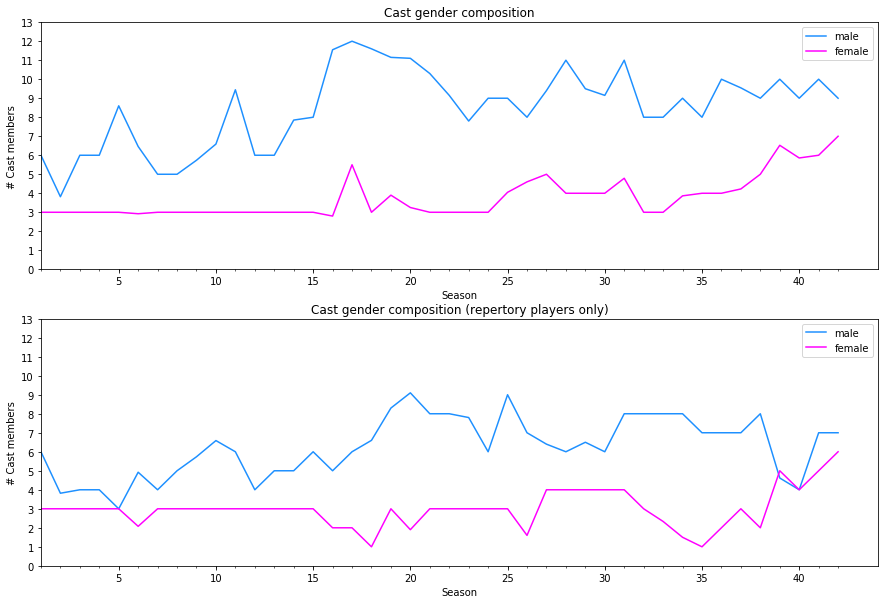

In [59]:
FS = (15, 10)
fig, (ax1, ax2) = plt.subplots(2, figsize=FS)
plot_cast_gender(ax1)
plot_cast_gender(ax2, include_featured=False)
ax2.set_title('Cast gender composition (repertory players only)');
# Note: "# cast members" can actually be non-integral to account for cast members who
# were around for only part of a season. e.g. Ben Stiller was only in the last 6 out of 20 episodes
# of season 14, so he's about 1/3 of a dude in that season for accounting purposes.

- There seems to be a clear 'glass floor' for female cast members, and it's at exactly n=3. No season has had fewer than 3 female cast members, but many have had *exactly* 3. (On the other hand, no season has had less than 5 male cast members, and that minimum was reached in only a small number of seasons)
- No season has ever had at least as many female cast members as male. Seasons 5, 39, and 40 had equal (or nearly equal) numbers across repertory players, but had more male featured players than female.
- Seasons 18 and 35 had only one female repertory player each (Julia Sweeney and Kristen Wiig, resp.)
- There seems to be a progressive trend over the last ~10 seasons. s42 has more female cast members than any other season and the highest f:m ratio (though it will go down a bit in 43 - the cast shakeup will be a net -1 female cast member and +1 male).

## Gender composition of sketches

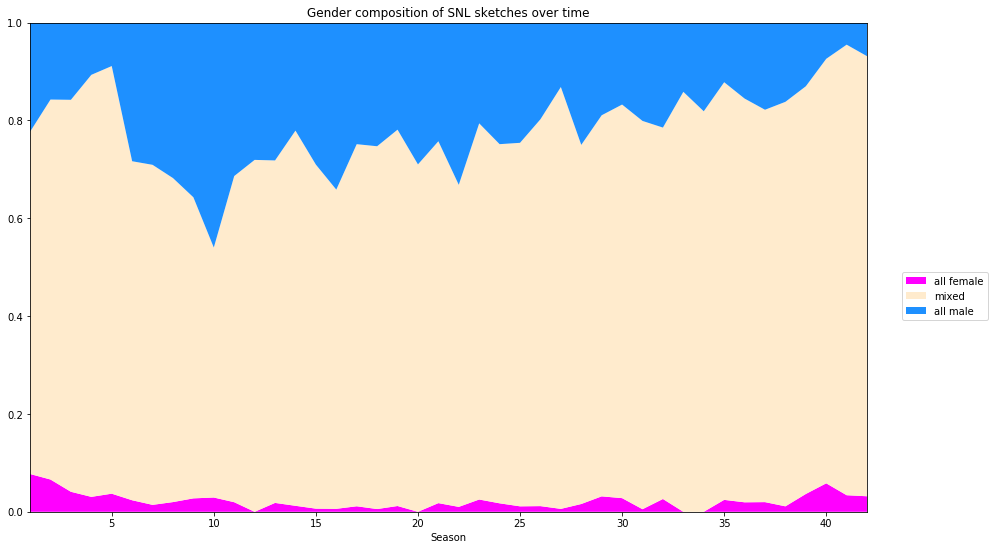

In [60]:
# Note: This does not include host Monologues or Weekend Update, since they're pretty constrained
# in terms of cast. It just counts 'sketches' (including commercials, digital shorts, etc.)
# Also, does not include solo performances.

ax, dat = plot_gender_ratio(monologues=False)
ax.set_title('Gender composition of SNL sketches over time');

This is interesting! Some observations:
- Overall, all-male sketches vastly outnumber all-female ones. There isn't a single season with more female sketches than male. (The closest is season 40, with 6% vs. 7%).
    - It would be interesting to see if this effect is greater than what would be expected after controlling for gender ratio of cast/hosts. (Doing this in a principled way seems kind of tricky. Probably need to describe some probability distribution from which we assume sketch casts are drawn)
- Surprisingly seasons 1 and 2 have the highest proportions of all-female sketches.
    - In effect, these seasons' casts were actually about the closest the show has ever come to gender equality. (The previous plots don't currently make this clear, because seasons 1 and 2 both had male cast members who were only present for small slices of the season. (e.g. George Coe was only credited in a single episode in s1, and Michael O'Donoghue only had 4 eps.)) For both seasons, there were essentially 3 women and 4 men present throughout the season.
    - Given that, it's kind of galling that 22% of sketches were all-male, vs. 7% all-female. (But again, should verify that intuition by seeing what the numbers would look like if we just simulate populating a bunch of sketches by selecting cast members uniformly at random).
- The number of all-female sketches has vaguely increased over the last couple decades, but it's a pretty weak trend. What's far more striking in its strength and consistency is the decrease in male-dominated sketches. Suggestive not just of more female representation on the show, but less segregation? 
    - (But again, to strengthen this claim, would want to see if it holds up after controlling for changes in the cast composition, and especially any changes in the distribution of number of players per sketch over time.)

In [61]:
if 0:
    perfs_range = range(1, 7)
    FS = (14, 5 * len(perfs_range))
    fig, axes = plt.subplots(len(perfs_range), figsize=FS)
    for min_perfs, ax in zip(perfs_range, axes):
        plot_gender_ratio(ax, monologues=False, min_performers=min_perfs)
        title = 'Gender composition of sketches (min performers = {})'.format(min_perfs)
        ax.set_title(title)

In [62]:
def sample_monogender_sketches(gender, n=10, sid_range=None, min_performers=2):
    assert gender in ('male', 'female')
    cats = gender_ratio_categories
    cols = ['category', 'name', 'epid', 'n_performers', 'n_female', 'n_male']
    target_ratio = 0 if gender == 'male' else 1
    title_idx = (
        titles['category'].isin(cats)
        & (titles['n_performers'] >= min_performers)
        & (titles['female_ratio'] == target_ratio)
    )
    if sid_range:
        title_idx &= (titles['sid'] >= sid_range[0]) & (titles['sid'] <= sid_range[1])
    return titles.loc[title_idx, cols].sample(n, random_state=1337)

## Example all-female/all-male sketches

In [63]:
sample_monogender_sketches('female', 20)

,category,name,epid,n_performers,n_female,n_male
tid,,,,,,
1993041712,Sketch,Carriage Ride,19930417,2,2.0,0.0
2012040711,Commercial,Lil Poundcake,20120407,3,3.0,0.0
200412183,Commercial,Woomba,20041218,4,4.0,0.0
198012134,Sketch,The Attack Of The Terrible Snapping Creatures,19801213,2,2.0,0.0
201605073,Commercial,President Barbie,20160507,2,2.0,0.0
2014051011,Commercial,Whiskers R' We,20140510,3,3.0,0.0
1977031211,Commercial,Gidget Goes To Shock Therapy,19770312,4,4.0,0.0
1982112018,Miscellaneous,Single,19821120,2,2.0,0.0
1991051114,Sketch,Shouting Mothers,19910511,3,2.0,0.0


In [64]:
sample_monogender_sketches('male', 20)

,category,name,epid,n_performers,n_female,n_male
tid,,,,,,
1991032314,Commercial,Buzz Pen,19910323,4,0.0,3.0
201605216,Film,"Farewell, Mr. Bunting",20160521,7,0.0,7.0
200601143,Commercial,Taco Town,20060114,4,0.0,4.0
200211021,Cold Opening,Endorsement Ads,20021102,4,0.0,4.0
200211161,Cold Opening,The Chanukah Song,20021116,2,0.0,2.0
199502111,Cold Opening,Colin Ferguson Trial,19950211,8,0.0,8.0
201311163,Commercial,Paxil: Second Term Strength,20131116,4,0.0,4.0
198304093,Show,The David Susskind Show,19830409,5,0.0,5.0
200210121,Cold Opening,Presidential Address,20021012,2,0.0,2.0


All-female sketches seem to be more explicitly about gender or 'girl stuff' (about half of the 20 above fit that description).

All-male sketches seem to be more wide ranging. Of the random 20 sampled above, there are only 2 or 3 that are about intrinsically or stereotypically male topics. ('Sigma', 'The Cardinals', and 'Father And Son').

(Er, the sampled sketches have changed since I wrote the above, but the broad strokes remain true.)

## Drag performances

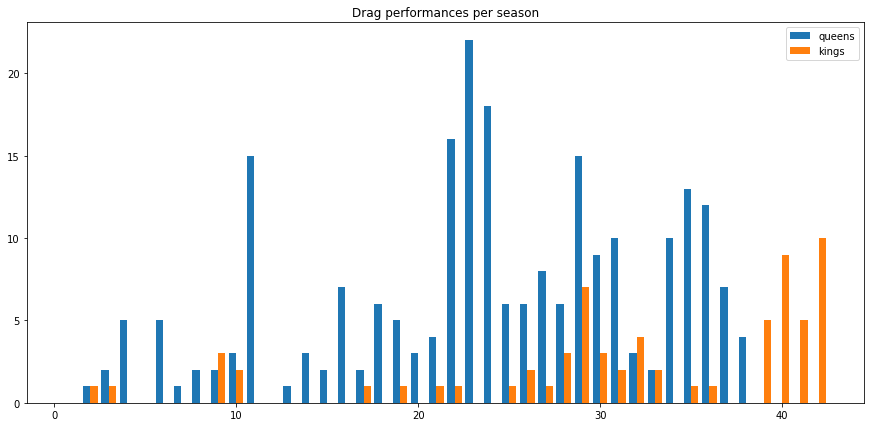

In [65]:
def plot_drag_over_time(ax=None):
    df = imps.merge(apps, on='impid')
    qpy = df.groupby('sid')['queen'].sum()
    kpy = df.groupby('sid')['king'].sum()
    if ax is None:
        FS = (15, 7)
        fig, ax = plt.subplots(figsize=FS)
    bar_width = .4
    ax.bar(qpy.index-bar_width/2, qpy.values, bar_width, label='queens')
    ax.bar(kpy.index+bar_width/2, kpy.values, bar_width, label='kings')
    ax.legend()
    return ax

ax = plot_drag_over_time()
ax.set_title('Drag performances per season');

Men performing in drag has definitely gone in and out of vogue on SNL. Most of it happened in the 90's and 00's, with a pretty big peak around the mid-90's. (Which might charitably be described as its most 'frattish' period. Janeane Garofalo, who was a cast member in '95, has been outspoken about how misogynistic she found the culture and humor at the time. The Nora Dunn/Andrew Dice Clay scandal also happened earlier that decade.)

Something really remarkable happened starting in season 39. Performances by male actors in drag vanished entirely, and women in male parts *skyrocketed*. There are two significant factors about the timing of this:
- s39 is around the time when the controversy about SNL having no black female cast members really took off. Around this time, Kenan Thompson vowed not to play any more black women on the show, as a sort of show of solidarity.
- s39 was Kate McKinnon's second season and first as a repertory player. She is (at least statistically) the most gifted impressionist in the modern era of SNL, and she's shown that that virtuosity extends to impersonating men, such as Justin Bieber or Jeff Sessions. I suspect most or even all of those orange bars are Kate.

Incidentally, there's a great passage from Tina Fey's book that's relevant to this topic:

> The only other thing I remember about the Sylvester Stallone show was that they did a Rocky-themed monologue and they needed someone to play Rocky's wife, Adrian. Cheri really wanted the part – she was little, she was from Philly, she could do a good imitation of Talia Shire – but instead, somebody thought it would be funnier to put her co-star Chris Kattan in a dress. I remember thinking that was kind of bullshit.

> [...] But I tell this specific tale of Cheri being passed over for Kattan-in-drag because it illustrates how things were the first week I was there. By the time I left nine years later, that would never have happened. The women in the cast took over the show in that decade, and I had the pleasure of being there to witness it.

In [66]:
from matplotlib.ticker import FormatStrFormatter
def plot_top_drag_performers(royal_col, n=10):
    df = imps.merge(apps, on='impid')
    drag_per_actor = df.groupby('actor_name_x')[royal_col].sum().sort_values(ascending=False).iloc[:n]\
        .sort_values()
    FS = (10, 7)
    fig, ax = plt.subplots(figsize=FS)
    
    nbars = min(n, len(drag_per_actor))
    y = range(nbars)
    ax.barh(y, drag_per_actor.values[:n])
    ax.set_yticks(y)
    ax.set_yticklabels(drag_per_actor.index[:n])
    ax.set_xticks(range(0, int(drag_per_actor.max()), 2))
    #ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
    return ax

## Top drag performers (female)

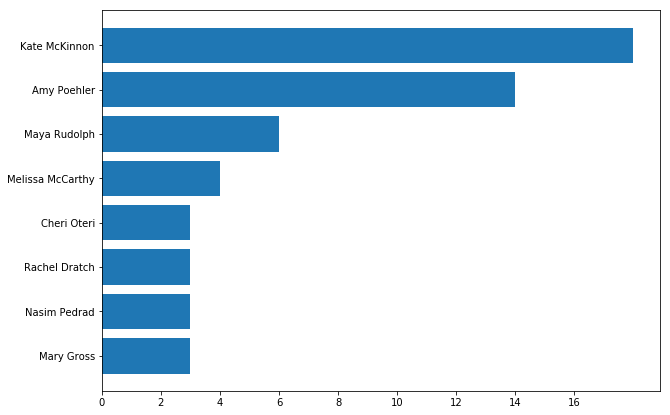

In [67]:
# (There are 8 female cast members who have performed in drag more than once.
# Another 10 or so have done it exactly once, plus a couple hosts)
plot_top_drag_performers('king', n=8);

As expected, Kate McKinnon rules the roost. Her dominance is especially impressive given that she presumably has a few years left of her SNL career (she's done 5 seasons - Amy Poehler and Maya Rudolph each did 8).

We can also see that the peak that came before her corresponds to the Fey era of early-mid-ish 2000's with performers like Amy Poehler, Maya Rudolph, and Rachel Dratch.

Amusingly, Melissa McCarthy places 4th on her Sean Spicer alone.

## Top drag performers (male)

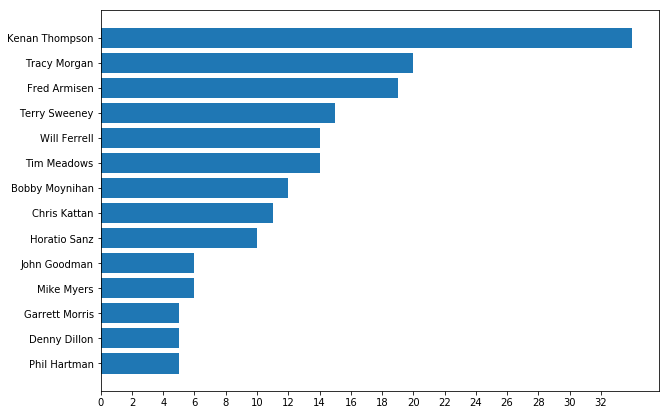

In [68]:
plot_top_drag_performers('queen', n=14);

Some notes:
- One can't help but feel that the top 2 drag performers being black men is a reflection of the dearth of black female performers on SNL. For much of Kenan and Tracy Morgan's tenures, there were no black women on the cast (Maya Rudolph joined toward the end of Tracy's run, and left near the beginning of Kenan's).
- Terry Sweeney is an interesting example as well. He did 8 impressions on the show, and *7* of them were women. Some important context: he was the only gay man to to ever be on SNL, and at a time when it wasn't easy to be gay and on TV. He's said that he had a hard time getting straight roles ("I think the writers came to think of me was just 'the gay guy'. They'd go like 'Oh, well, he's a hilarious gay guy, so if we want a gay guy, we'll just put him in this sketch where the guy can be really effeminate.'"). Perhaps he discovered that performing in drag was another means for him to get written into sketches.
- There are a few interesting absences. Darrell Hammond, Taran Killam, and Bill Hader, the performers with the 2nd, 4th, and 5th most impressions done on the show, don't make the list. Taran Killam impersonated 95 different people and *none* of them were women.
- Another host makes the list: John Goodman. He did one sketch as Anna Nicole Smith, but the rest are from when he impersonated Linda Tripp - he was sort of the Melissa McCarthy of the 90's, I guess.

In [69]:
if 0:
    tm = imps['actor_name']=='Tracy Morgan'
    print "Tracy morgan did {} impressions, {} female".format(tm.sum(), (tm & (imps['queen'])).sum())
    imps[tm]
if 0:
    ts = imps['actor_name']=='Terry Sweeney'
    imps[ts]
if 0:
    x = {'Darrell Hammond', 'Taran Killam', 'Bill Hader'}
    imps[
        imps['actor_name'].isin(x) & imps['queen']
    ]

# Emerging themes

Some threads that seem like they might be worth tugging on more...

## SNL and the rise of political spectacle. 

Last season gave SNL its biggest ratings in decades because the election and early stages of Trump's presidency gave them tons of material, and they spun it into gold and pulled off a lot of successful impressions. 

I think in the data on season 42 there's some compelling evidence for what a singularly political season it was.

But the data also suggests that this is, to some degree, a continuation of an ongoing trend toward more political content. Among Gerald Ford, Jimmy Carter, Ronald Reagan, and George Bush, none of them was impersonated as many times as *any* president that came after (Clinton, GWB, Obama, and yes, even Trump).

## Cast member ecological niches

The data often makes it clear who's really good at doing impressions and who can't do them at all. Or who's getting written into a lot of sketches but never in starring roles. 

Not yet explored but could be interesting:
- The end of the show is usually reserved for more experimental or risky material. Which actors rule the 'ten-to-one' slot?
- Career arcs. What does the trajectory of a typical SNL career look like in terms of their presence on the show over time? Which featured players have had the most meteoric starts, and which ones had a slow burn?

## Representations of women on SNL

I already wrote a lot about this above, but, as much as it's sort of a trite/expected topic, I do think the data offers a lot to unpack on this topic.

# Works in progress / graveyard

Explorations that are still in a messy stage / never went anywhere.

## Top Recurring Sketches

In [71]:
rec = titles[pd.notnull(titles['skid'])]
skid_counts = rec.groupby('skid').size().to_frame(name='count').reset_index(level=0)
skid_counts = pd.merge(skid_counts, sketches, on='skid')
skid_counts.sort_values(by='count', ascending=False, inplace=True)
skid_counts.head(20)
# Well this is kind of a mess!

,skid,count,name
224,230,105,SNL Digital Short
4,5,40,A Film by Gary Weis
132,135,31,Fun With Real Audio
17,18,29,Schiller's Reel
231,237,26,MacGruber
8,9,22,The Mr. Bill Show
183,188,20,Hardball
79,80,19,Wayne's World
66,67,19,Church Chat
98,100,18,Daily Affirmation


## Cast airtime (pt 2 - arcs)

In [72]:
def airtime_over_time(aid, metric='episode_share'):
    c = casts[casts['aid']==aid]
    x =  c['sid'].values
    y = [airtime_one_season(yr, metric) for yr in c.itertuples()]
    return x, y

def plot_airtime_over_time(aids, metric='episode_share'):
    """Given some actor ids, make a plot, where x axis is seasons and y axis is avg.
    airtime (according to given metric). One line drawn per actor.
    """
    FS = (11, 5)
    fig, ax = plt.subplots(figsize=FS)
    for aid in aids:
        x, y = airtime_over_time(aid, metric)
        ax.plot(x, y, label=actors.loc[aid, 'name'])
        
    ax.set_xlabel('Season')
    ax.set_ylabel(metric)
    ax.legend()
    return ax

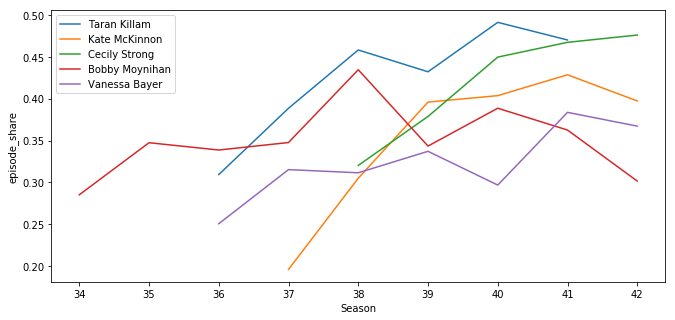

In [73]:
ax = plot_airtime_over_time(['c_TaKi', 'c_KaMc', 'c_CeSt', 'c_BoMo', 'c_VaBa']);

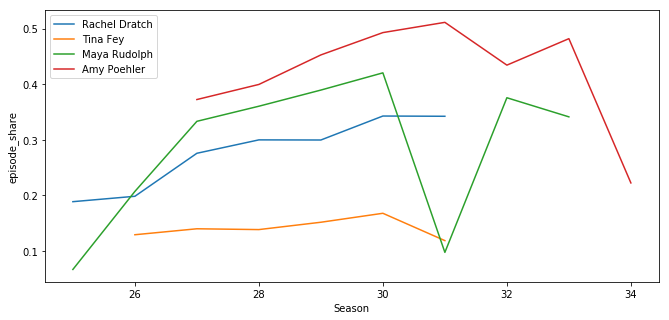

In [74]:
# Women who started around 2000-2001-ish
y2k = ['Tina Fey', 'Rachel Dratch', 'Maya Rudolph', 'Amy Poehler']
yaids = actors.loc[actors['name'].isin(y2k), 'aid']
ax = plot_airtime_over_time(yaids);

In [75]:
ats = season_airtimes(39)
ats.head()

,aid,featured,first_epid,last_epid,sid,update_anchor,actor_name,n_episodes,season_fraction,cast_episode_share,n_titles,episode_share
2,c_SaZa,True,20140118.0,NaN,39,False,Sasheer Zamata,11,0.52381,0.380337,28,2.490909
17,c_BrWh,True,NaN,NaN,39,False,Brooks Wheelan,21,1.00000,0.595506,49,4.369814
18,c_NoWe,True,NaN,NaN,39,False,Noël Wells,21,1.00000,0.644642,59,5.236674
36,c_KeTh,False,NaN,NaN,39,False,Kenan Thompson,21,1.00000,1.514017,99,8.709829
55,c_CeSt,False,NaN,NaN,39,True,Cecily Strong,21,1.00000,1.330864,89,7.955167


In [76]:
ats.sort_values(by='n_titles', ascending=False)

,aid,featured,first_epid,last_epid,sid,update_anchor,actor_name,n_episodes,season_fraction,cast_episode_share,n_titles,episode_share
306,c_TaKi,False,NaN,NaN,39,False,Taran Killam,21,1.000000,1.450756,102,9.077001
36,c_KeTh,False,NaN,NaN,39,False,Kenan Thompson,21,1.000000,1.514017,99,8.709829
275,c_KaMc,False,NaN,NaN,39,False,Kate McKinnon,21,1.000000,1.276234,93,8.315423
55,c_CeSt,False,NaN,NaN,39,True,Cecily Strong,21,1.000000,1.330864,89,7.955167
215,c_BoMo,False,NaN,NaN,39,False,Bobby Moynihan,21,1.000000,1.185518,82,7.211538
525,c_VaBa,False,NaN,NaN,39,False,Vanessa Bayer,21,1.000000,1.239619,80,7.079915
497,c_AiBr,False,NaN,NaN,39,False,Aidy Bryant,21,1.000000,1.114460,79,6.948951
512,c_BeBe,True,NaN,NaN,39,False,Beck Bennett,21,1.000000,1.063556,70,6.128205
156,c_JaPh,False,NaN,NaN,39,False,Jay Pharoah,21,1.000000,0.981868,69,6.098757
18,c_NoWe,True,NaN,NaN,39,False,Noël Wells,21,1.000000,0.644642,59,5.236674


TODO: #s for Sasheer and Nasim seem pretty low. Are we denominating correctly for incomplete seasons?
Actually, looks like Nasim was there for the whole season. How can she have been in fewer sketches than Kyle Mooney?

An average episode has around 15 segments. After subtracting goodnights and musical performances, that leaves around 12 for cast members to star in. So you only need an 'episode share' of a little under .1 to appear on average once a week.

## Solo performances

In [92]:
sts = titles[
    (titles['n_performers']==1) 
    & ~(titles['category'].isin({'Monologue', 'Weekend Update'}))
    & (titles['sid'] >= 25)
]
solo_apps = sts.merge(apps, on='tid')
solos_per_actor = solo_apps.groupby('actor_name').size()
solos_per_actor.sort_values(ascending=False).head(15)

actor_name
Darrell Hammond    13
Will Ferrell        9
Andy Samberg        8
Chris Parnell       8
Jason Sudeikis      8
Bill Hader          6
Taran Killam        6
Fred Armisen        6
Kristen Wiig        5
Amy Poehler         4
Kyle Mooney         3
Ana Gasteyer        3
Horatio Sanz        3
Kate McKinnon       3
Ashton Kutcher      2
dtype: int64